# Classifying patients at risk for heart failure using clinical data
By Mara Sánchez, Eric Yang & Omar Ramos 2025/11/21

In [1]:
import requests
import warnings
import pandas as pd
import altair_ally as aly
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.exceptions import UndefinedMetricWarning
import json
import logging
warnings.filterwarnings("ignore", category=FutureWarning, module="deepchecks")
warnings.filterwarnings("ignore", category=UserWarning, module="deepchecks")
warnings.filterwarnings("ignore", module="altair")
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="pandera")
import pandera as pa
from deepchecks.tabular import Dataset
from deepchecks.tabular.checks import FeatureLabelCorrelation, FeatureFeatureCorrelation

# Summary

In this analysis, we explored various classification models with the intent of predicting whether a patient is at risk of heart failure based on clinical data and lifestyle factors of individuals. After evaluating multiple models through cross-validation, we selected Logistic Regression as our final model due to its overall superior performance across classification metrics. The model demonstrated promising results on the unseen test set, with an accuracy of 86% and F1-scores of 0.88 for the positive class (at risk) and 0.84 for the negative class (not at risk). From the 276 observations in the test set, the model correctly identified 144 cases at risk and 97 not at risk, reporting 23 false positives and 12 false negatives (cases predicted as not at risk when there is risk). Although the scores are encouraging for a first iteration, there is room for improvement to optimize the hyperparameters and the model's threshold settings to minimize false negative cases, which are critical in medical applications. Overall, this model shows potential to support clinical professionals in the assessment of patients during screening. 


# Introduction

Cardiovascular diseases (CVDs) represent the leading cause of death worldwide, responsible for an estimate of 19.8 million deaths in 2022 and accounting for one-third of all deaths globally in people under the age of 70 ([World Health Organization, 2025](https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds))).  Most CVDs have proven to have a big correlation with an individual’s behavior, habits and environment ([American Heart Association, 2025](https://professional.heart.org/-/media/phd-files-2/science-news/2/2025-heart-and-stroke-stat-update/factsheets/2025-stats-update-fact-sheet-global-burden-of-disease.pdf)). Heart Failure (HF) is a multi-faceted and life-threatening syndrome where the heart’s ability to pump and/or fill with blood is reduced, it is estimated to affect more than 64 million people globally ([Savarese _et al._, 2022](hhttps://pubmed.ncbi.nlm.nih.gov/35150240/)). Risk factors such as high blood pressure, high blood glucose levels or pre-existing diseases require early intervention to avoid the risk of developing heart failure and other complications. Since many of these risk factors are clinically measurable and changeable, early intervention is highly possible and a critical opportunity in contributing to a patient's well-being.


This issue leads to the question of whether a machine learning (ML) model could reliably classify patients as ‘at-risk’ or ‘not-at-risk’ for heart failure based on clinical and lifestyle features. The study of this question is important because traditional risk assessment methods tend to overlook the variability and the complexity of the risk factors, meaning that subjectivity from healthcare professionals could also impact the outcome of the assessment ([Barnett _et al._, 2020](https://pmc.ncbi.nlm.nih.gov/articles/PMC7379092/)). Missing the early detection of risk of HF could lead to chronic and progressive conditions associated with increase in mortality and decrease in quality of life. Additionally, ML algorithms could offer significant advantages in predicting risk of HF, when integrating it to clinical practice it could allow for a more personalized treatment for the patient ([Kokori _et al._, 2025](https://pubmed.ncbi.nlm.nih.gov/39656330/)). 


# Methods

The [dataset](https://epl.di.uminho.pt/~jcr/AULAS/ATP2021/datasets/heart.csv)  used in this project is pulled from a repository of the [University of Minho,  Portugal](https://www.uminho.pt/EN/student-life/campi/Pages/Description.aspx). The dataset was created by Federico Soriano Palacios (2021), it integrates five different heart-related datasets combined over 11 common features that can be used to predict a possible heart disease. The five data sets are part of the [“Heart Disease” dataset](https://archive.ics.uci.edu/dataset/45/heart+disease) (Janosi _et al._, 1989) that can be found in the UCI Machine Learning Repository  that is originally sourced from the Hungarian Institute of Cardiology, the University Hospital of Zurich, the University Hospital of Basel, the V.A. Medical Center of Long Beach and Cleveland Clinic Foundation. Each row of the dataset contains 11 attributes that describe the patient’s age, sex, chest pain type, resting blood pressure, serum cholesterol, fasting blood sugar, resting ECG result, maximum heart rate achieved, exercise induced angina, ST depression induced by exercise relative to rest, slope of the peak exercise ST segment, and the presence or absence of heart disease. 



To build the classification model for the prediction of heart failure risk, an exploratory data analysis was conducted. Considering the distribution of the data, the features and their correlation to the target variable, it was decided to include all of them in the model with some standardization to improve results. Data was split into 70% for the training set and 30% for the test set. Different approaches were taken to evaluate which model would have the best accuracy in classification.  We trained five different models, including Decision Tree, k-nearest neighbors (k-nn), Support Vector Machine (SVC) with an RBF kernel, Logistic Regression, and a Dummy Classifier (baseline). Each of the models were evaluated using a 5-fold cross-validation strategy. Model performance was evaluated using metrics such as accuracy, precision, recall, and F1-score. The model with the highest performance scores across all metrics is the Logistic Regression which is the model that will be used for the rest of the project. The Python programming language (Van Rossum and Drake 2009) and the following Python packages were used to perform the analysis: NumPy (Harris et al. 2020), pandas (McKinney 2010), Matplotlib (Hunter 2007), seaborn (Waskom 2021), Altair (VanderPlas et al. 2018), scikit-learn (Pedregosa et al. 2011), and requests (Reitz 2011).

# Results & Discussion

We conducted some initial exploratory data analysis by observing the number of observations, data types of the features, and checked for missing values. We also inspected the categorical counts for some features to better understand their distribution. The distribution of the target variable was observed to be balanced with approximately equal representation of both classes.

To evaluate the usefulness of each feature to predict the heart disease, we investigated the distribution of each feature with respect to the target variable. We also visualized the correlation between features using a heatmap to identify any strong relationships.


In [2]:
url = "https://epl.di.uminho.pt/~jcr/AULAS/ATP2021/datasets/heart.csv"

response = requests.get(url)

with open("../data/raw/heart.csv", "wb") as f:
    f.write(response.content)

In [3]:
heart_disease = pd.read_csv('../data/raw/heart.csv')
heart_disease

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [4]:
# Configure logging
logging.basicConfig(
    filename="../logs/validation_errors.log",
    filemode="w",
    format="%(asctime)s - %(message)s",
    level=logging.INFO,
)

In [5]:
schema = pa.DataFrameSchema(
    {
        "Age": pa.Column(int, pa.Check.between(20, 90)),
        "Sex": pa.Column(str, pa.Check.isin(["F", "M"])),
        "ChestPainType": pa.Column(str, pa.Check.isin(["TA", "ATA", "NAP", "ASY"])),
        "RestingBP": pa.Column(int, pa.Check.between(80, 230)),
        "Cholesterol": pa.Column(int, pa.Check.between(50, 400)),
        "FastingBS": pa.Column(int, pa.Check.isin([0, 1])),
        "RestingECG": pa.Column(str, pa.Check.isin(["Normal", "ST", "LVH"])),
        "MaxHR": pa.Column(int, pa.Check.between(60, 202)),
        "ExerciseAngina": pa.Column(str, pa.Check.isin(["Y", "N"])),
        "Oldpeak": pa.Column(float, pa.Check.between(-4.0, 6.2)),
        "ST_Slope": pa.Column(str, pa.Check.isin(["Up", "Flat", "Down"])),
        "HeartDisease": pa.Column(int, pa.Check.isin([0, 1])),
    },
    checks=[
        pa.Check(lambda df: ~df.duplicated().any(), error="Duplicate rows found."),
        pa.Check(lambda df: ~(df.isna().all(axis=1)).any(), error="Empty rows found."),
    ],
    drop_invalid_rows=False,
)

In [6]:
# Make a copy so original is untouched
data = heart_disease.copy()
error_cases = pd.DataFrame()

In [7]:
try:
    # Validate with lazy errors (UBC: lazy=True)
    validated_data = schema.validate(data, lazy=True)

except pa.errors.SchemaErrors as e:
    # Find invalid rows
    error_cases = e.failure_cases

    # Log JSON message
    error_message = json.dumps(e.message, indent=2)
    logging.error("\n" + error_message)

# Filter out invalid rows
if not error_cases.empty:
    invalid_indices = error_cases["index"].dropna().unique()
    validated_data = (
        data.drop(index=invalid_indices)
            .reset_index(drop=True)
            .drop_duplicates()
            .dropna(how="all")
    )
    print(f"Dropped {len(invalid_indices)} invalid rows.")
else:
    validated_data = data
    print("No validation errors found.")

Dropped 185 invalid rows.


In [8]:
validated_data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
728,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
729,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
730,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
731,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [9]:
train_df, test_df = train_test_split(validated_data, test_size=0.3, random_state=123)

In [10]:
X_train = train_df.drop(columns=["HeartDisease"])
X_test = test_df.drop(columns=["HeartDisease"])
y_train = train_df["HeartDisease"]
y_test = test_df["HeartDisease"]

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 513 entries, 294 to 510
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             513 non-null    int64  
 1   Sex             513 non-null    object 
 2   ChestPainType   513 non-null    object 
 3   RestingBP       513 non-null    int64  
 4   Cholesterol     513 non-null    int64  
 5   FastingBS       513 non-null    int64  
 6   RestingECG      513 non-null    object 
 7   MaxHR           513 non-null    int64  
 8   ExerciseAngina  513 non-null    object 
 9   Oldpeak         513 non-null    float64
 10  ST_Slope        513 non-null    object 
 11  HeartDisease    513 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 52.1+ KB


In [12]:
train_df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000
mean,52.998051,132.592593,239.654971,0.167641,141.126706,0.866472,0.467836
std,9.556473,17.235833,50.067297,0.373912,24.358038,1.053235,0.499451
min,28.000000,92.000000,85.000000,0.000000,71.000000,0.000000,0.000000
25%,46.000000,120.000000,205.000000,0.000000,124.000000,0.000000,0.000000
50%,54.000000,130.000000,235.000000,0.000000,142.000000,0.500000,0.000000
75%,60.000000,140.000000,273.000000,0.000000,160.000000,1.500000,1.000000
max,76.000000,200.000000,394.000000,1.000000,195.000000,6.200000,1.000000


In [13]:
train_df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [14]:
train_df[train_df.iloc[:, :-1].eq(0).any(axis=1)]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
294,63,M,ASY,170,177,0,Normal,84,Y,2.5,Down,1
692,58,M,ATA,120,284,0,LVH,160,N,1.8,Flat,1
245,62,M,ATA,140,271,0,Normal,152,N,1.0,Up,0
142,43,F,ATA,120,249,0,ST,176,N,0.0,Up,0
591,38,M,TA,120,231,0,Normal,182,Y,3.8,Flat,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17,43,F,ATA,120,201,0,Normal,165,N,0.0,Up,0
98,40,F,ASY,150,392,0,Normal,130,N,2.0,Flat,1
322,61,M,ASY,146,241,0,Normal,148,Y,3.0,Down,1
365,48,M,NAP,132,220,1,ST,162,N,0.0,Flat,1


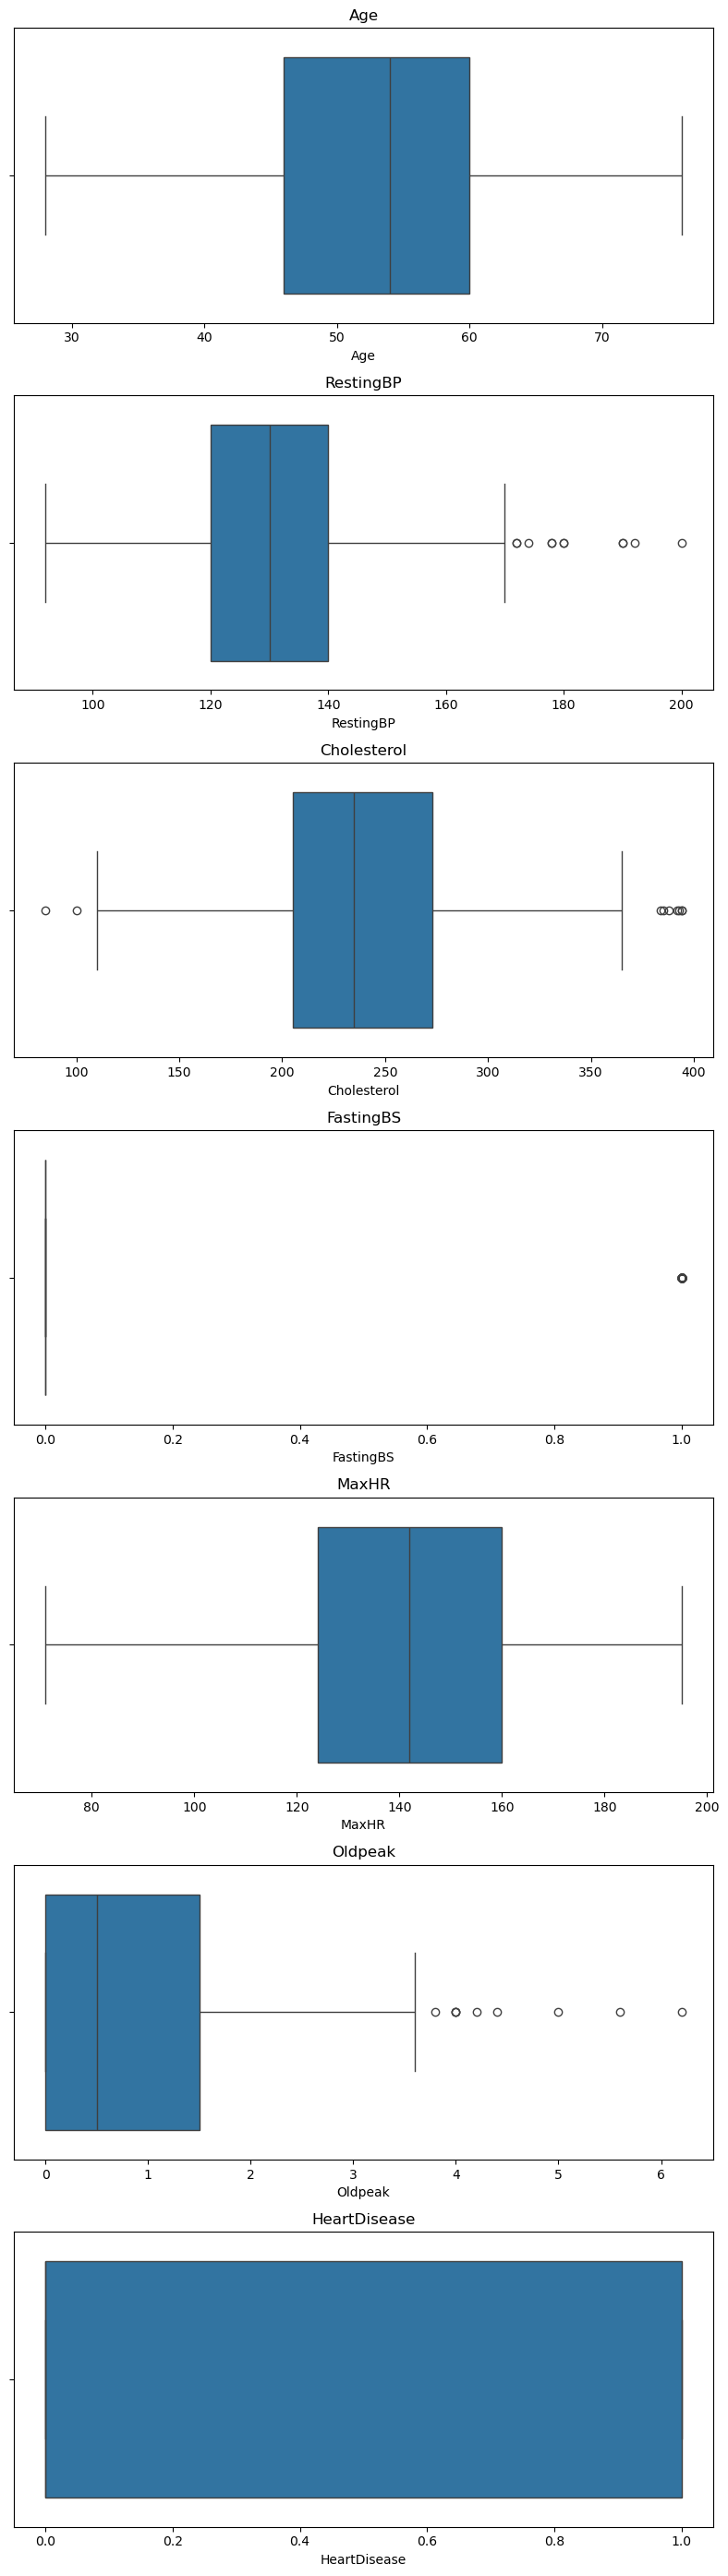

In [15]:
numeric_cols = train_df.select_dtypes(include='number').columns

fig, axes = plt.subplots(nrows=len(numeric_cols), ncols=1, figsize=(8, 4*len(numeric_cols)))

for ax, col in zip(axes, numeric_cols):
    sns.boxplot(x=train_df[col], ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()

_Figure 1. Boxplots of Numeric Features_

In [16]:
train_df['HeartDisease'] = train_df['HeartDisease'].astype('bool')

In [17]:
aly.alt.data_transformers.enable('vegafusion')

aly.dist(train_df, color='HeartDisease')

alt.ConcatChart(...)

_Figure 2. Comparison of numerical predictors, coloured by heart disease status._

In [18]:
aly.dist(train_df.assign(HeartDisease=lambda train_df: train_df['HeartDisease'].astype(object)), 
         dtype='object', color='HeartDisease')

alt.ConcatChart(...)

_Figure 3. Distribution of categorical predictors, coloured by heart disease status._

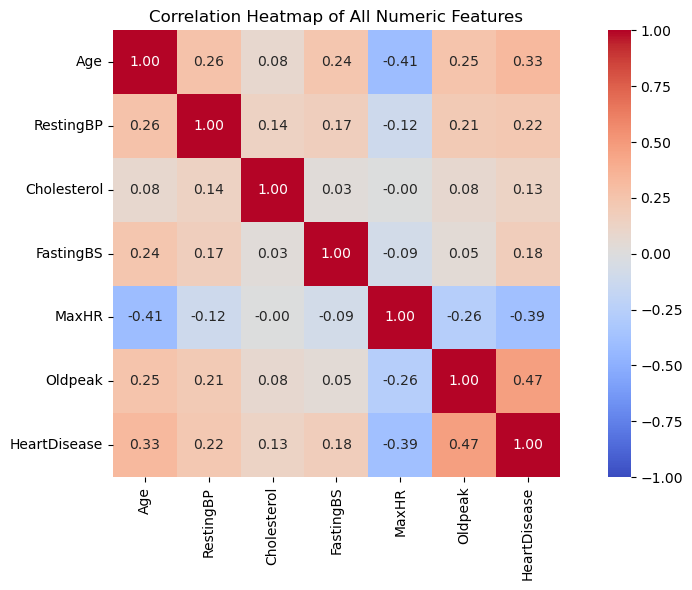

In [19]:
corr = train_df.corr(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f", 
    cmap="coolwarm",
    vmin=-1, vmax=1,
    square=True
)

plt.title("Correlation Heatmap of All Numeric Features")
plt.tight_layout()
plt.show()

_Figure 3. Correlation heatmap of all numerical features in the dataset._

We are not dropping any features as all features seem to be relevant to predicting heart disease based on the EDA.

In [20]:
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [21]:
# --- Start of code block copied from another author ---
# Title: Function to consolidate cross validation scores into a pandas series.
# Author: Varada Kolhatkar & Michael Gelbart
# Source: https://pages.github.ubc.ca/mds-2025-26/DSCI_571_sup-learn-1_students/README.html 
# Taken from: DSCI-571: Laboratory 2
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)
# --- End of code block copied from another author ---

In [22]:
numeric_transformer = StandardScaler()

In [23]:
preprocessor = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(drop='if_binary', 
                   handle_unknown="ignore", 
                   sparse_output=False
                  ), categorical_features),
)
preprocessor

,transformers,"[('standardscaler', ...), ('onehotencoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [24]:
# Define Classification Metrics for scoring
classification_metrics = ["accuracy", "precision", "recall", "f1"]

In [25]:
heart_train_ds = Dataset(
    train_df,
    label="HeartDisease",
    cat_features=categorical_features
)

# Check: Feature-label correlation
check_feat_lab_corr = FeatureLabelCorrelation().add_condition_feature_pps_less_than(0.9)
check_feat_lab_corr_result = check_feat_lab_corr.run(dataset=heart_train_ds)

# Check: Feature-feature correlation
check_feat_feat_corr = (
    FeatureFeatureCorrelation()
    .add_condition_max_number_of_pairs_above_threshold(n_pairs=0, threshold=0.95)
)
check_feat_feat_corr_result = check_feat_feat_corr.run(dataset=heart_train_ds)

if not check_feat_lab_corr_result.passed_conditions():
    raise ValueError("Feature-label correlation exceeds the maximum acceptable threshold.")

if not check_feat_feat_corr_result.passed_conditions():
    raise ValueError("Feature-feature correlation exceeds the maximum acceptable threshold.")

check_feat_lab_corr_result, check_feat_feat_corr_result


(Feature Label Correlation: {'ST_Slope': 0.6608611600415604, 'ExerciseAngina': 0.5375846313497734, 'ChestPainType': 0.500045446858965, 'Oldpeak': 0.4077483173780496, 'Age': 0.25732994497267986, 'MaxHR': 0.1753152205220387, 'Cholesterol': 0.13369582906946587, 'Sex': 0.12726113428948255, 'RestingBP': 0.07612334022483921, 'RestingECG': 0.03949641108359879, 'FastingBS': 0.0},
 Feature-Feature Correlation:                      Age RestingBP Cholesterol FastingBS     MaxHR   Oldpeak  \
 Age                  1.0  0.284635    0.100234  0.236954 -0.384245  0.309213   
 RestingBP       0.284635       1.0    0.105394  0.176754 -0.123487  0.222952   
 Cholesterol     0.100234  0.105394         1.0  0.028244  0.016816  0.113214   
 FastingBS       0.236954  0.176754    0.028244       1.0 -0.077528  0.095137   
 MaxHR          -0.384245 -0.123487    0.016816 -0.077528       1.0 -0.324181   
 Oldpeak         0.309213  0.222952    0.113214  0.095137 -0.324181       1.0   
 Sex             0.068479  0.

## Models Evaluation

We decided to initiate our analysis considering a set of classification models including Decision Tree, kNN, SVM (with RBF kernel), Logistic Regression, and a dummy classifier as a baseline. 
All models were trained and evaluated using a 5-fold cross-validation strategy. The performance classification metrics used to evaluate the models were accuracy, precision, recall and F1-score.

Initially, the models were trained using default hyperparameters to define a model that would be further optimized in subsequent steps for this project.

The configuration and results of the cross-validations are detailed below:

In [26]:
# Define models to evaluate
models = {
    "dummy": DummyClassifier(random_state=123),
    "decision_tree": DecisionTreeClassifier(random_state=123),
    "kNN": KNeighborsClassifier(),
    "SVM": SVC(random_state=123),
    #"naive_bayes": MultinomialNB(),
    "logistic_regression": LogisticRegression(random_state=123, max_iter=1000)
}

In [27]:
# Build pipeline function
def build_pipe(model):
    return make_pipeline(preprocessor, model)

In [28]:
# Execute cross-validation for each model and store results
results_dict = {}

for estimator in models:
    results_dict[estimator] = mean_std_cross_val_scores(
        build_pipe(models[estimator]),
        X_train,
        y_train,
        cv=5,
        return_train_score=True,
        scoring=classification_metrics
    )
    results_df = pd.DataFrame(results_dict)

results_df

,dummy,decision_tree,kNN,SVM,logistic_regression
fit_time,0.003 (+/- 0.001),0.004 (+/- 0.000),0.006 (+/- 0.005),0.006 (+/- 0.000),0.013 (+/- 0.014)
score_time,0.004 (+/- 0.000),0.004 (+/- 0.000),0.020 (+/- 0.012),0.006 (+/- 0.001),0.012 (+/- 0.003)
test_accuracy,0.532 (+/- 0.003),0.760 (+/- 0.057),0.819 (+/- 0.028),0.854 (+/- 0.015),0.850 (+/- 0.024)
train_accuracy,0.532 (+/- 0.001),1.000 (+/- 0.000),0.884 (+/- 0.006),0.905 (+/- 0.002),0.864 (+/- 0.006)
test_precision,0.000 (+/- 0.000),0.745 (+/- 0.062),0.804 (+/- 0.040),0.837 (+/- 0.027),0.833 (+/- 0.029)
train_precision,0.000 (+/- 0.000),1.000 (+/- 0.000),0.871 (+/- 0.009),0.899 (+/- 0.008),0.854 (+/- 0.003)
test_recall,0.000 (+/- 0.000),0.742 (+/- 0.070),0.812 (+/- 0.036),0.854 (+/- 0.000),0.850 (+/- 0.023)
train_recall,0.000 (+/- 0.000),1.000 (+/- 0.000),0.882 (+/- 0.009),0.899 (+/- 0.009),0.856 (+/- 0.014)
test_f1,0.000 (+/- 0.000),0.743 (+/- 0.063),0.808 (+/- 0.029),0.846 (+/- 0.014),0.841 (+/- 0.025)
train_f1,0.000 (+/- 0.000),1.000 (+/- 0.000),0.876 (+/- 0.007),0.899 (+/- 0.002),0.855 (+/- 0.007)


_Table 1. Cross-validation 5-folds results for all models._

After performing the cross-validation, we observed that both the Logistic Regression and SVM models had the best performance across all metrics, with Logistic Regression slightly outperforming SVM all-around. 

Based on this, we decided to choose the Logistic Regression model as our final model for predicting heart disease risk. 

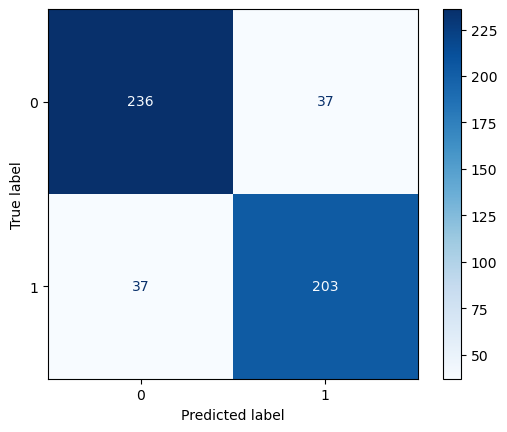

In [29]:
# Confusion Matrix for Logistic Regression
lr_pipe = make_pipeline(preprocessor, 
                        LogisticRegression(random_state=123, max_iter=1000))

conf_mat_logreg = ConfusionMatrixDisplay.from_estimator(
    #build_pipe["logistic_regression"].fit(X_train, y_train),
    lr_pipe.fit(X_train, y_train),
    X_train,
    y_train,
    values_format="d",
    cmap='Blues'
)
conf_mat_logreg


_Figure 4. Confusion matrix for Logistic Regression model - Train set._

## Evaluation on Test Set

In [30]:
# Evaluate on Test Set
# Classification report

y_pred = lr_pipe.predict(X_test)

classification_rep = classification_report(y_test, y_pred)
print(classification_rep)


              precision    recall  f1-score   support

           0       0.87      0.89      0.88       112
           1       0.89      0.86      0.87       108

    accuracy                           0.88       220
   macro avg       0.88      0.88      0.88       220
weighted avg       0.88      0.88      0.88       220



_Table 2. Classification Report for Test Set._

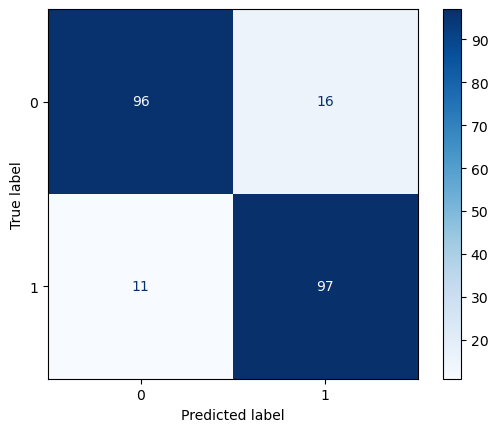

In [31]:
# Confusion Matrix for Logistic Regression model on Test Set

conf_mat_logreg = ConfusionMatrixDisplay.from_estimator(
    lr_pipe.fit(X_test, y_test),
    X_test,
    y_test,
    values_format="d",
    cmap='Blues'
)
conf_mat_logreg

_Figure 5. Confusion matrix for Logistic Regression model - Test set._

The initial results of the Logistic Regression prediction model on the test set showed good performance across all metrics, as detailed in Table 2. This matched our expectations based on the cross-validation results, indicating that the model would generalize well on unseen data. This is already a positive outcome for a first iteration of the model and provides a solid foundation for further improvements. It also has the potential to be useful as a support tool for clinical screening of patients.

Aside from the hyperparameter tuning that will be explored on future stages, this use case is well suited for Precision-Recall and Receiver Operating Characteristic (ROC) curve analysis to further evaluate the model's threshold settings and trade-offs between precision and recall. This is a medical-related application, and it is crucial to minimize false negatives i.e., predicting a patient is not at risk when they actually are. Also, making the probability scores available for the predictions could increase the model's utility, supporting the decision-making of healthcare professionals. 

Finally, we could review the features coefficients from the Logistic Regression model to understand their influence on the predictions, enabling to better interpret the model's decisions and confirm if we could drop any features in future iterations.

# References

1. American Heart Association. (2025). 2025 Heart & Stroke Statistics Update Fact Sheet: Global burden of disease [PDF]. https://professional.heart.org/-/media/phd-files-2/science-news/2/2025-heart-and-stroke-stat-update/factsheets/2025-stats-update-fact-sheet-global-burden-of-disease.pdf
 

2. Barnett, M. P., Koppes, L. L. J., & … [et al.]. (2020). Cardiovascular risk factors: It’s time to focus on variability! Frontiers in Cardiovascular Medicine, 7, Article 80. https://doi.org/10.3389/fcvm.2020.00080
 (PMC published version) https://pmc.ncbi.nlm.nih.gov/articles/PMC7379092/

3.  Federico Soriano Palacios. (September 2021). Heart Failure Prediction Dataset. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/heart-failure-prediction.

4. Harris, C.R. et al., 2020. Array programming with NumPy. Nature, 585, pp.357–362.

5. J. D. Hunter, "Matplotlib: A 2D Graphics Environment", Computing in Science & Engineering, vol. 9, no. 3, pp. 90-95, 2007.
 
6. Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1989). Heart Disease [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

7. Kokori, E., Patel, R., Olatunji, G., Ukoaka, B. M., Abraham, I. C., Ajekiigbe, V. O., Kwape, J. M., Babalola, A. E., Udam, N. G., & Aderinto, N. (2025). Machine learning in predicting heart failure survival: A review of current models and future prospects. Heart Failure Reviews, 30(2), 431–442. https://doi.org/10.1007/s10741-024-10474-y
 https://pubmed.ncbi.nlm.nih.gov/39656330/

8. McKinney, Wes. 2010. “Data Structures for Statistical Computing in Python.” In Proceedings of the 9th Python in Science Conference, edited by Stéfan van der Walt and Jarrod Millman, 51–56.
 
9. Pedregosa, F. et al., 2011. Scikit-learn: Machine learning in Python. Journal of machine learning research, 12(Oct), pp.2825–2830.

10. Reitz, Kenneth. 2011. Requests: HTTP for Humans. https://requests.readthedocs.io/en/master/.

11. Savarese, G., Lund, L. H., & Becher, P. M. (2023). Global burden of heart failure: A comprehensive and updated review of epidemiology. Cardiovascular Research, 118(17), 3272–3287. https://doi.org/10.1093/cvr/cvac013
 https://pubmed.ncbi.nlm.nih.gov/35150240/

12. Van Rossum, Guido, and Fred L. Drake. 2009. Python 3 Reference Manual. Scotts Valley, CA: CreateSpace.

13. VanderPlas, J. et al., 2018. Altair: Interactive statistical visualizations for python. Journal of open source software, 3(32), p.1057.

14. World Health Organization. (2024, August 8). Cardiovascular diseases (CVDs) – fact sheet. https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)

15. Waskom, M. L., (2021). seaborn: statistical data visualization. Journal of Open Source Software, 6(60), 3021, https://doi.org/10.21105/joss.03021.

